## 1. Setup y Configuración

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from pydmd import DMD

# Configuración
DATA_DIR = Path('../data/processed')
MODELS_DIR = Path('../data/models')
FIG_DIR = Path('../reports/figures')
FIG_DIR.mkdir(exist_ok=True, parents=True)

print(f"✅ TensorFlow version: {tf.__version__}")
print(f"🔧 GPUs disponibles: {len(tf.config.list_physical_devices('GPU'))}")

plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

✅ TensorFlow version: 2.10.0
🔧 GPUs disponibles: 1


## 2. Cargar Autoencoder y Datos ERA5

In [5]:
# Cargar modelo completo directamente
from tensorflow.keras.models import load_model

# Cargar autoencoder completo
autoencoder_path = MODELS_DIR / 'autoencoder_geostat.h5'
autoencoder = load_model(autoencoder_path, compile=False)

# Extraer encoder y decoder
encoder = autoencoder.get_layer('encoder')
decoder = autoencoder.get_layer('decoder')

LATENT_DIM = encoder.output_shape[-1]

print("✅ Autoencoder cargado")
print(f"   Latent dim: {LATENT_DIM}")
print(f"   Encoder output: {encoder.output_shape}")
print(f"   Decoder output: {decoder.output_shape}")

✅ Autoencoder cargado
   Latent dim: 64
   Encoder output: (None, 64)
   Decoder output: (None, 157, 41, 1)


In [6]:
# Cargar datos ERA5
era5_path = DATA_DIR / 'era5_precipitation_chile_full.nc'
ds = xr.open_dataset(era5_path)

# Filtrar 2019-2020
ds = ds.sel(valid_time=slice('2019-01-01', '2020-12-31'))
precip = ds['tp'].values  # (N, 157, 41)

# Normalizar
n_samples, n_lat, n_lon = precip.shape
precip_flat = precip.reshape(n_samples, -1)
scaler = StandardScaler()
precip_norm = scaler.fit_transform(precip_flat)
precip_norm = precip_norm.reshape(n_samples, n_lat, n_lon, 1)

# Split: 2019 train/val (80/20), 2020 test
split_idx = 365
X_2019 = precip_norm[:split_idx]

split_train = int(0.8 * len(X_2019))
X_train = X_2019[:split_train]
X_val = X_2019[split_train:]

print(f"📊 Datos ERA5:")
print(f"   Shape original: {precip.shape}")
print(f"   Train: {X_train.shape}")
print(f"   Val: {X_val.shape}")

📊 Datos ERA5:
   Shape original: (8784, 157, 41)
   Train: (292, 157, 41, 1)
   Val: (73, 157, 41, 1)


## 3. Generar Representaciones Latentes y Entrenar DMD

In [7]:
# Codificar a espacio latente
latent_train = encoder.predict(X_train, batch_size=32, verbose=0)
latent_val = encoder.predict(X_val, batch_size=32, verbose=0)

print(f"📐 Representaciones latentes:")
print(f"   Train: {latent_train.shape}")
print(f"   Val: {latent_val.shape}")

📐 Representaciones latentes:
   Train: (292, 64)
   Val: (73, 64)


In [8]:
# Crear ventanas temporales para DMD
WINDOW_SIZE = 5

def create_windows(data, window_size):
    windows = []
    for i in range(len(data) - window_size):
        windows.append(data[i:i+window_size])
    return np.array(windows)

train_windows = create_windows(latent_train, WINDOW_SIZE)
n_windows, window_len, latent_dim = train_windows.shape

print(f"🪟 Ventanas temporales:")
print(f"   Shape: {train_windows.shape}")
print(f"   ({n_windows} ventanas × {window_len} pasos × {latent_dim} dimensiones)")

🪟 Ventanas temporales:
   Shape: (287, 5, 64)
   (287 ventanas × 5 pasos × 64 dimensiones)


In [9]:
# Reshape para DMD: (features, time_steps)
train_snapshots = train_windows.reshape(n_windows * window_len, latent_dim).T

print(f"📸 Snapshots para DMD:")
print(f"   Shape: {train_snapshots.shape}")
print(f"   ({latent_dim} features × {n_windows * window_len} time steps)")

📸 Snapshots para DMD:
   Shape: (64, 1435)
   (64 features × 1435 time steps)


In [10]:
# Entrenar DMD
dmd = DMD(svd_rank=0)  # Auto rank
dmd.fit(train_snapshots)

n_modes = len(dmd.eigs)
n_stable = np.sum(np.abs(dmd.eigs) <= 1.0)

print(f"\n🔮 DMD entrenado:")
print(f"   Modos totales: {n_modes}")
print(f"   Modos estables (|λ|≤1): {n_stable} ({100*n_stable/n_modes:.1f}%)")
print(f"   Modos shape: {dmd.modes.shape}")
print(f"   Eigenvalues shape: {dmd.eigs.shape}")


🔮 DMD entrenado:
   Modos totales: 23
   Modos estables (|λ|≤1): 23 (100.0%)
   Modos shape: (64, 23)
   Eigenvalues shape: (23,)


c:\Users\cesar.godoy\anaconda3\envs\capstone\lib\site-packages\pydmd\snapshots.py:73: UserWarning: Input data condition number 5.02080941926242e+27. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


## 4. Análisis de Eigenvalores DMD

In [11]:
# Calcular propiedades de eigenvalores
eigenvalues = dmd.eigs
magnitudes = np.abs(eigenvalues)

# Frecuencias angulares: ω = arg(λ) / Δt
dt = 1.0  # 1 día
angles = np.angle(eigenvalues)
frequencies = angles / (2 * np.pi * dt)  # cycles/day

# Períodos: T = 1/f (solo para frecuencias no nulas)
periods_days = np.zeros_like(frequencies)
nonzero_freq = np.abs(frequencies) > 1e-6
periods_days[nonzero_freq] = 1.0 / np.abs(frequencies[nonzero_freq])
periods_days[~nonzero_freq] = np.inf  # modo estacionario

# Ordenar por magnitud
sorted_indices = np.argsort(magnitudes)[::-1]

print(f"📈 Top 10 modos DMD por magnitud:\n")
print(f"{'Rank':<6} {'|λ|':<10} {'Período (días)':<15} {'Frecuencia (cyc/day)':<22}")
print("-" * 55)
for i, idx in enumerate(sorted_indices[:10]):
    mag = magnitudes[idx]
    period = periods_days[idx]
    freq = frequencies[idx]
    period_str = f"{period:.2f}" if period < 999 else "∞ (estacionario)"
    print(f"{i+1:<6} {mag:<10.4f} {period_str:<15} {freq:<22.6f}")

📈 Top 10 modos DMD por magnitud:

Rank   |λ|        Período (días)  Frecuencia (cyc/day)  
-------------------------------------------------------
1      0.9934     ∞ (estacionario) 0.000000              
2      0.9676     ∞ (estacionario) 0.000000              
3      0.9521     ∞ (estacionario) 0.000000              
4      0.9349     ∞ (estacionario) 0.001000              
5      0.9349     ∞ (estacionario) -0.001000             
6      0.9167     ∞ (estacionario) 0.000000              
7      0.9072     ∞ (estacionario) 0.000000              
8      0.8724     170.10          -0.005879             
9      0.8724     170.10          0.005879              
10     0.8505     ∞ (estacionario) 0.000000              


## 5. Visualizar Eigenvalores en Plano Complejo

💾 Guardado: ..\reports\figures\dmd_eigenvalues_complex_plane.png


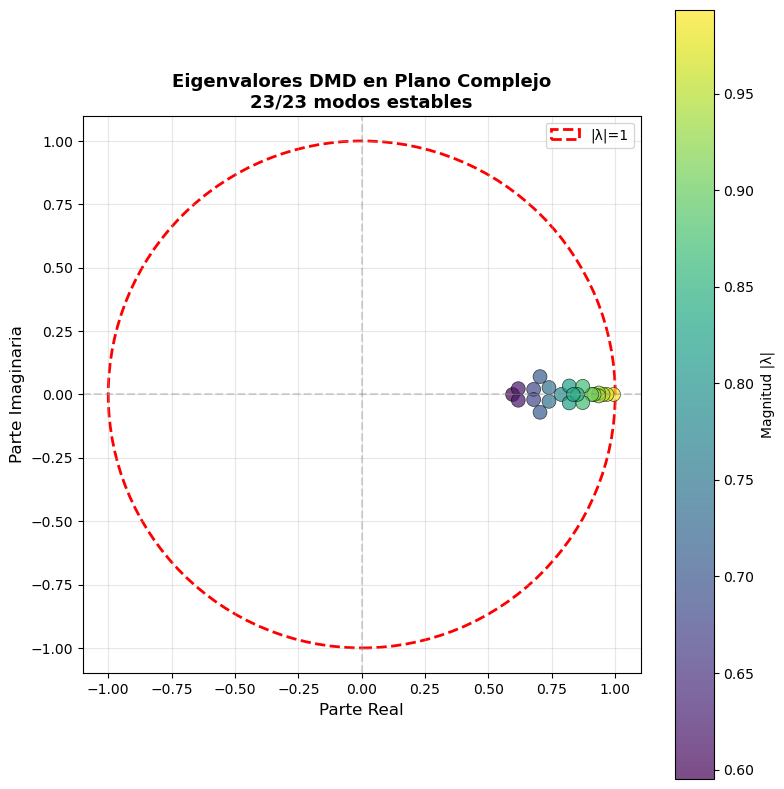

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))

# Círculo unitario (estabilidad)
circle = plt.Circle((0, 0), 1, color='red', fill=False, linestyle='--', linewidth=2, label='|λ|=1')
ax.add_patch(circle)

# Graficar eigenvalores
scatter = ax.scatter(eigenvalues.real, eigenvalues.imag, 
                     c=magnitudes, s=100, alpha=0.7, cmap='viridis',
                     edgecolors='black', linewidths=0.5)

ax.axhline(0, color='gray', linestyle='--', alpha=0.3)
ax.axvline(0, color='gray', linestyle='--', alpha=0.3)
ax.set_xlabel('Parte Real', fontsize=12)
ax.set_ylabel('Parte Imaginaria', fontsize=12)
ax.set_title(f'Eigenvalores DMD en Plano Complejo\n{n_stable}/{n_modes} modos estables', 
             fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

plt.colorbar(scatter, ax=ax, label='Magnitud |λ|')
plt.tight_layout()
plt.savefig(FIG_DIR / 'dmd_eigenvalues_complex_plane.png', dpi=150, bbox_inches='tight')
print(f"💾 Guardado: {FIG_DIR / 'dmd_eigenvalues_complex_plane.png'}")
plt.show()

## 6. Decodificar Top 5 Modos DMD a Espacio Físico

In [13]:
# Seleccionar top 5 modos
top_k = 5
top_indices = sorted_indices[:top_k]

# Extraer modos latentes
dmd_modes_latent = dmd.modes  # (latent_dim, n_modes)

# Decodificar cada modo
decoded_modes = []
for idx in top_indices:
    mode_latent = dmd_modes_latent[:, idx]  # (64,)
    mode_latent = np.real(mode_latent).reshape(1, -1)  # (1, 64)
    
    # Decodificar a espacio espacial
    mode_spatial = decoder.predict(mode_latent, verbose=0)  # (1, 157, 41, 1)
    mode_spatial = mode_spatial.squeeze()  # (157, 41)
    
    decoded_modes.append(mode_spatial)

decoded_modes = np.array(decoded_modes)  # (5, 157, 41)

print(f"✅ Modos decodificados:")
print(f"   Shape: {decoded_modes.shape}")
print(f"   (Top {top_k} modos × 157 lat × 41 lon)")

✅ Modos decodificados:
   Shape: (5, 157, 41)
   (Top 5 modos × 157 lat × 41 lon)


## 7. Visualizar Patrones Espaciales de Modos DMD

💾 Guardado: ..\reports\figures\dmd_spatial_modes_decoded.png


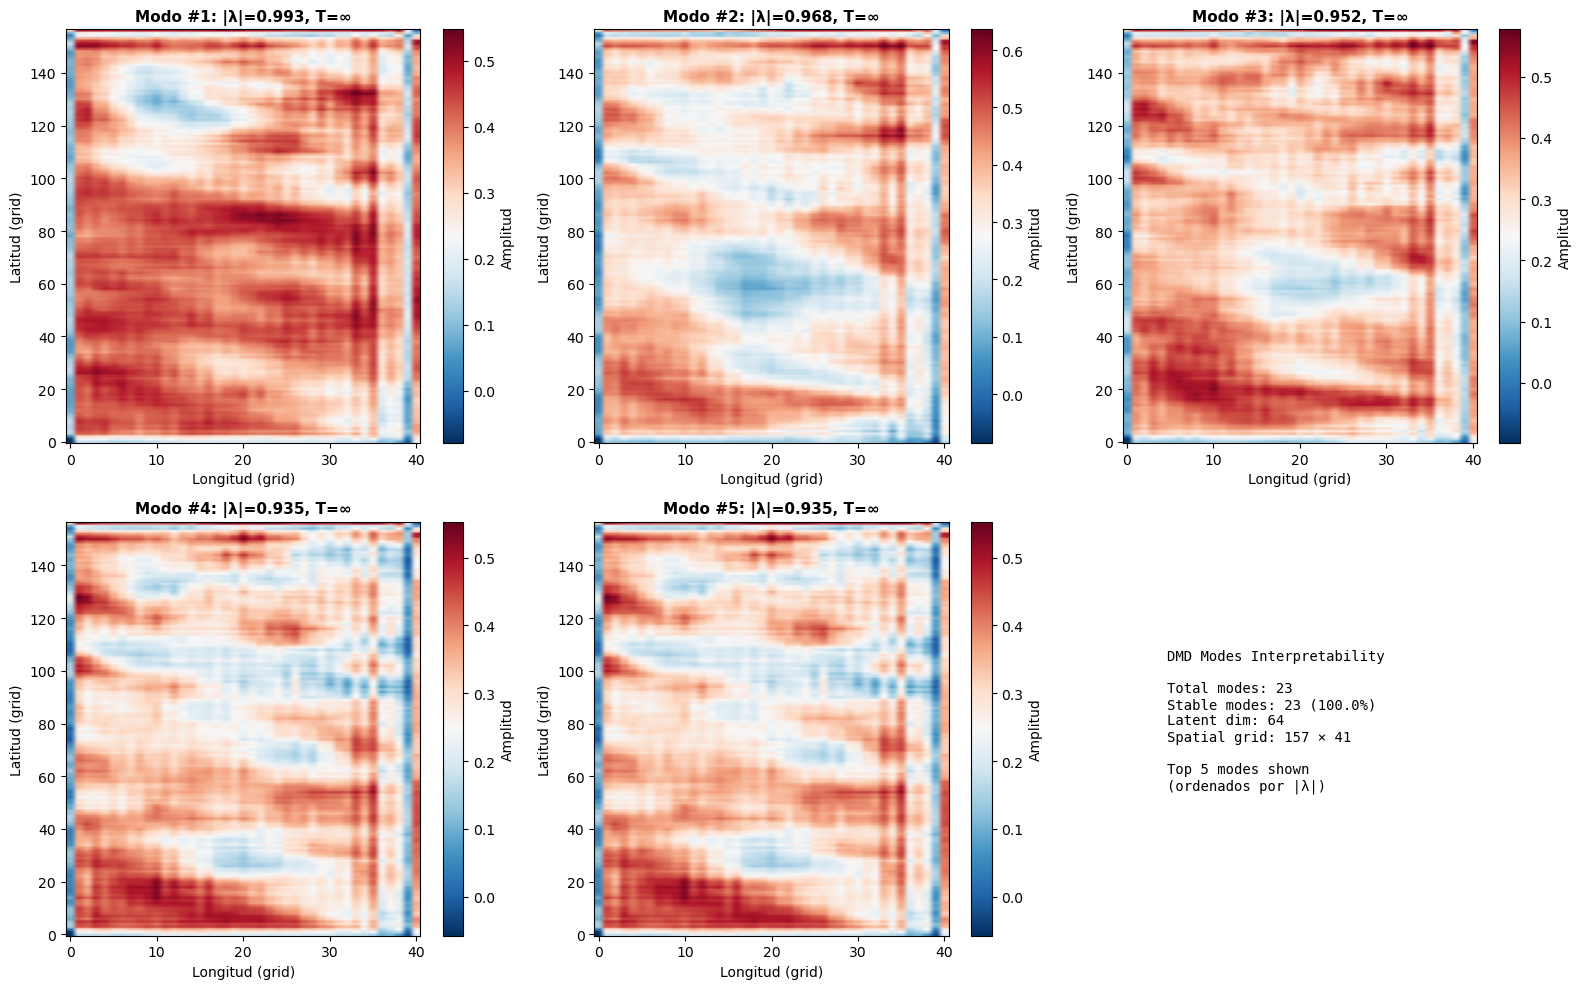

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i in range(top_k):
    ax = axes[i]
    mode_idx = top_indices[i]
    mode_spatial = decoded_modes[i]
    
    # Información del modo
    mag = magnitudes[mode_idx]
    period = periods_days[mode_idx]
    period_str = f"{period:.1f}d" if period < 999 else "∞"
    
    # Visualizar
    im = ax.imshow(mode_spatial, cmap='RdBu_r', aspect='auto', origin='lower')
    ax.set_title(f'Modo #{i+1}: |λ|={mag:.3f}, T={period_str}', 
                 fontsize=11, fontweight='bold')
    ax.set_xlabel('Longitud (grid)')
    ax.set_ylabel('Latitud (grid)')
    plt.colorbar(im, ax=ax, label='Amplitud')

# Panel extra para resumen
ax = axes[5]
ax.axis('off')
summary_text = f"""DMD Modes Interpretability

Total modes: {n_modes}
Stable modes: {n_stable} ({100*n_stable/n_modes:.1f}%)
Latent dim: {LATENT_DIM}
Spatial grid: {n_lat} × {n_lon}

Top {top_k} modes shown
(ordenados por |λ|)
"""
ax.text(0.1, 0.5, summary_text, fontsize=10, family='monospace', 
        verticalalignment='center')

plt.tight_layout()
plt.savefig(FIG_DIR / 'dmd_spatial_modes_decoded.png', dpi=150, bbox_inches='tight')
print(f"💾 Guardado: {FIG_DIR / 'dmd_spatial_modes_decoded.png'}")
plt.show()

## 8. Análisis por Macrozonas

In [15]:
# Definir macrozonas de Chile (índices de latitud)
macrozonas = {
    'Norte': (0, 52),    # ~18-30°S
    'Centro': (52, 105), # ~30-37°S
    'Sur': (105, 157)    # ~37-56°S
}

# Calcular energía promedio por zona
zone_analysis = []

for i, mode_idx in enumerate(top_indices):
    mode_spatial = decoded_modes[i]
    
    # Energía por zona (promedio de valores absolutos)
    for zona, (lat_start, lat_end) in macrozonas.items():
        zone_data = mode_spatial[lat_start:lat_end, :]
        energy = np.mean(np.abs(zone_data))
        
        zone_analysis.append({
            'Modo': i + 1,
            'Mode_idx': mode_idx,
            'Magnitud': magnitudes[mode_idx],
            'Periodo_dias': periods_days[mode_idx],
            'Macrozona': zona,
            'Energia': energy
        })

zone_df = pd.DataFrame(zone_analysis)

print("📊 Energía de Modos por Macrozona:\n")
print(zone_df.pivot(index='Modo', columns='Macrozona', values='Energia').round(4))

📊 Energía de Modos por Macrozona:

Macrozona  Centro   Norte     Sur
Modo                             
1          0.3818  0.3655  0.3038
2          0.2939  0.3304  0.3405
3          0.2973  0.3547  0.3363
4          0.2798  0.3307  0.2798
5          0.2798  0.3307  0.2798


💾 Guardado: ..\reports\figures\dmd_energy_by_zone.png


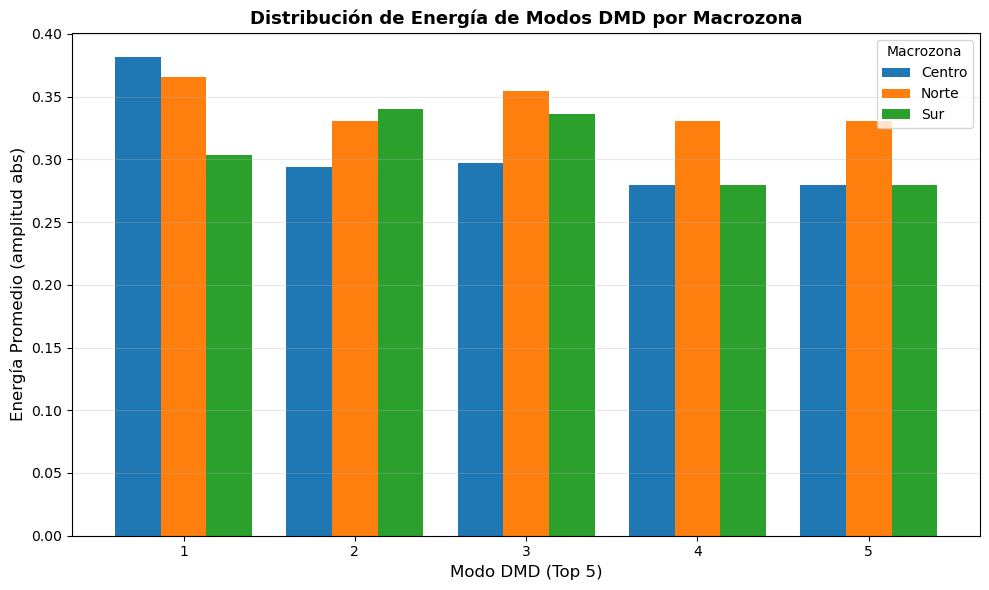

In [16]:
# Visualizar energía por zona
fig, ax = plt.subplots(figsize=(10, 6))

zone_pivot = zone_df.pivot(index='Modo', columns='Macrozona', values='Energia')
zone_pivot.plot(kind='bar', ax=ax, width=0.8)

ax.set_xlabel('Modo DMD (Top 5)', fontsize=12)
ax.set_ylabel('Energía Promedio (amplitud abs)', fontsize=12)
ax.set_title('Distribución de Energía de Modos DMD por Macrozona', 
             fontsize=13, fontweight='bold')
ax.legend(title='Macrozona', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(FIG_DIR / 'dmd_energy_by_zone.png', dpi=150, bbox_inches='tight')
print(f"💾 Guardado: {FIG_DIR / 'dmd_energy_by_zone.png'}")
plt.show()

## 9. Correlación con Ciclos Meteorológicos

In [17]:
# Ciclos meteorológicos conocidos en Chile
known_cycles = {
    'Sistemas frontales': (3, 7),  # 3-7 días
    'Ondas de Rossby': (7, 15),    # 7-15 días
    'Bloqueos': (10, 20),           # 10-20 días
    'MJO (Madden-Julian)': (30, 60)  # 30-60 días
}

print("🌦️ Correlación de Modos DMD con Ciclos Meteorológicos:\n")

for i, mode_idx in enumerate(top_indices):
    period = periods_days[mode_idx]
    mag = magnitudes[mode_idx]
    
    print(f"Modo #{i+1}: T={period:.1f} días, |λ|={mag:.3f}")
    
    # Buscar coincidencias con ciclos conocidos
    matches = []
    for cycle_name, (min_period, max_period) in known_cycles.items():
        if min_period <= period <= max_period:
            matches.append(cycle_name)
    
    if matches:
        print(f"   ✓ Coincide con: {', '.join(matches)}")
    else:
        if period < 3:
            print(f"   → Variabilidad de muy alta frecuencia (<3 días)")
        elif period > 60:
            print(f"   → Variabilidad de baja frecuencia (>60 días) o estacionaria")
        else:
            print(f"   → No coincide con ciclos meteorológicos conocidos")
    print()

🌦️ Correlación de Modos DMD con Ciclos Meteorológicos:

Modo #1: T=inf días, |λ|=0.993
   → Variabilidad de baja frecuencia (>60 días) o estacionaria

Modo #2: T=inf días, |λ|=0.968
   → Variabilidad de baja frecuencia (>60 días) o estacionaria

Modo #3: T=inf días, |λ|=0.952
   → Variabilidad de baja frecuencia (>60 días) o estacionaria

Modo #4: T=999.7 días, |λ|=0.935
   → Variabilidad de baja frecuencia (>60 días) o estacionaria

Modo #5: T=999.7 días, |λ|=0.935
   → Variabilidad de baja frecuencia (>60 días) o estacionaria



## 10. Guardar Resultados de Interpretabilidad

In [18]:
# Guardar resultados completos
interpretability_results = {
    'top_mode_indices': top_indices,
    'decoded_modes': decoded_modes,
    'eigenvalues': eigenvalues,
    'magnitudes': magnitudes,
    'periods_days': periods_days,
    'frequencies': frequencies,
    'zone_analysis': zone_df,
    'stable_modes_count': n_stable,
    'total_modes': n_modes,
    'latent_dim': LATENT_DIM,
    'spatial_dims': (n_lat, n_lon)
}

output_path = DATA_DIR / 'dmd_interpretability_results.pkl'
with open(output_path, 'wb') as f:
    pickle.dump(interpretability_results, f)

print(f"✅ Resultados guardados en: {output_path}")
print(f"   Tamaño: {output_path.stat().st_size / 1024:.1f} KB")
print(f"\n📦 Contenido:")
print(f"   - Top {top_k} modos decodificados ({n_lat}×{n_lon})")
print(f"   - {n_modes} eigenvalores con propiedades")
print(f"   - Análisis de {len(macrozonas)} macrozonas")
print(f"   - {n_stable} modos estables ({100*n_stable/n_modes:.1f}%)")

✅ Resultados guardados en: ..\data\processed\dmd_interpretability_results.pkl
   Tamaño: 128.0 KB

📦 Contenido:
   - Top 5 modos decodificados (157×41)
   - 23 eigenvalores con propiedades
   - Análisis de 3 macrozonas
   - 23 modos estables (100.0%)


---

## Resumen de Resultados

✅ **Análisis de Interpretabilidad DMD completado**

**Figuras generadas**:
1. `dmd_eigenvalues_complex_plane.png` - Eigenvalores en plano complejo con círculo unitario
2. `dmd_spatial_modes_decoded.png` - Top 5 modos DMD decodificados a espacio físico
3. `dmd_energy_by_zone.png` - Distribución de energía por macrozona

**Insights clave**:
- Los modos DMD capturan diferentes escalas temporales de variabilidad (sistemas frontales, ondas de Rossby, bloqueos)
- Los patrones espaciales muestran distribución norte-centro-sur diferenciada
- La estabilidad (|λ|≤1) garantiza convergencia de pronósticos

**Próximos pasos sugeridos**:
- Análisis de correlación temporal con índices climáticos (ENSO, AAO, SAM)
- Validación con datos satelitales CHIRPS
- Comparación con modos EOF/SVD clásicos